In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.neighbors import LocalOutlierFactor

# Load data

In [2]:
params = pd.read_csv('model_params.csv')
print(params.shape)

(156, 36)


In [3]:
params.head()

,C,DV,E_K,El,Tref,Vr,Vt_star,cell_type,dt,eta_10.0,...,h_tau,lambda0,m_A,m_Vhalf,m_k,n_A,n_Vhalf,n_k,name,type
0,0.094361,5.151288,-101.0,-58.838751,6.5,-53.551984,-54.175906,5HT,0.1,0.017711,...,33.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN307,AugmentedGIF
1,0.114852,3.100761,-101.0,-78.706007,6.5,-54.555621,-52.020721,5HT,0.1,0.031279,...,33.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN308,AugmentedGIF
2,0.112754,1.247224,-101.0,-63.624398,6.5,-56.135385,-46.530925,5HT,0.1,0.070692,...,61.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN317,AugmentedGIF
3,0.087860,2.369712,-101.0,-59.121382,6.5,-55.919281,-44.936669,5HT,0.1,0.022100,...,82.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN318,AugmentedGIF
4,0.121158,4.977856,-101.0,-50.061295,6.5,-49.185461,-58.738916,5HT,0.1,0.048414,...,33.0,1.0,1.61,-23.7,0.0985,1.55,-24.3,0.216,DRN319,AugmentedGIF


In [4]:
params.columns

Index([u'C', u'DV', u'E_K', u'El', u'Tref', u'Vr', u'Vt_star', u'cell_type',
       u'dt', u'eta_10.0', u'eta_100.0', u'eta_1000.0', u'eta_3.0',
       u'eta_30.0', u'eta_300.0', u'eta_3000.0', u'gamma_3.0', u'gamma_30.0',
       u'gamma_300.0', u'gamma_3000.0', u'gbar_K1', u'gbar_K2', u'gl', u'h_A',
       u'h_Vhalf', u'h_k', u'h_tau', u'lambda0', u'm_A', u'm_Vhalf', u'm_k',
       u'n_A', u'n_Vhalf', u'n_k', u'name', u'type'],
      dtype='object')

# Select GIFs and remove unnecessary features

In [5]:
params_cleaned = params.copy()
params_cleaned.drop(columns=['Tref', 'dt', 'E_K', 'gbar_K1', 'gbar_K2', 'h_A', 'h_Vhalf', 'h_k', 'lambda0', 'm_A', 'm_Vhalf', 'm_k', 'n_A', 'n_Vhalf', 'n_k', 'h_tau'], inplace=True)
params_cleaned = params_cleaned.loc[params_cleaned['type'] == 'GIF', :]
params_cleaned.drop(columns=['name', 'type'], inplace=True)

cell_types = params_cleaned['cell_type']
params_cleaned.drop(columns=['cell_type'], inplace=True)

params_cleaned.head()

,C,DV,El,Vr,Vt_star,eta_10.0,eta_100.0,eta_1000.0,eta_3.0,eta_30.0,eta_300.0,eta_3000.0,gamma_3.0,gamma_30.0,gamma_300.0,gamma_3000.0,gl
18,0.099165,6.537423,-64.456700,-53.551984,-55.723169,0.008590,0.028477,0.002652,0.055727,-0.003865,-0.000222,0.000670,68849.738479,-46.686658,6.983622,5.327227,0.001101
19,0.121812,4.442023,-80.402978,-54.555621,-54.317823,0.024262,0.038746,0.008135,0.079653,-0.013658,0.007560,-0.003254,-63.497849,60.990898,37.533114,2.546485,0.001341
20,0.115125,2.417979,-64.851407,-56.135385,-49.111013,0.068537,0.055866,0.002841,-0.025442,-0.022652,0.006485,-0.001052,-94.415131,91.663755,10.192265,0.146151,0.002272
21,0.094173,3.813900,-63.565351,-55.919281,-46.181507,0.017409,0.057299,0.003776,-0.016150,-0.002213,-0.003999,-0.000593,-176.953457,185.704229,6.839458,-0.171109,0.001654
22,0.105769,4.568117,-54.186544,-49.185461,-59.392968,0.030981,0.007375,0.007067,-0.067469,0.026209,0.000226,-0.006007,807.045568,-1.874450,0.443651,2.199422,0.001898


In [6]:
print(params_cleaned.columns)

Index([u'C', u'DV', u'El', u'Vr', u'Vt_star', u'eta_10.0', u'eta_100.0',
       u'eta_1000.0', u'eta_3.0', u'eta_30.0', u'eta_300.0', u'eta_3000.0',
       u'gamma_3.0', u'gamma_30.0', u'gamma_300.0', u'gamma_3000.0', u'gl'],
      dtype='object')


In [7]:
print(params_cleaned.shape)

(39, 17)


# Detect outliers

/miniconda3/envs/neopozz/lib/python2.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


(array([26.,  7.,  2.,  0.,  1.,  1.,  0.,  0.,  1.,  1.]),
 array([-5.02640366e-03,  5.01821096e-01,  1.00866860e+00,  1.51551610e+00,
         2.02236360e+00,  2.52921110e+00,  3.03605860e+00,  3.54290610e+00,
         4.04975360e+00,  4.55660110e+00,  5.06344860e+00]),
 <a list of 10 Patch objects>)

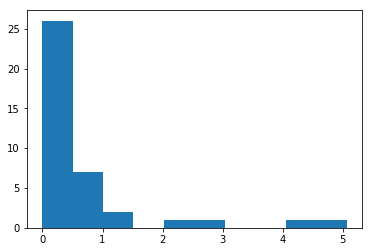

In [8]:
outlier_detector = LocalOutlierFactor(n_neighbors=20)
outlier_detector.fit(params_cleaned)
plt.hist(np.log10(-outlier_detector.negative_outlier_factor_))

In [9]:
cell_types[np.log10(-outlier_detector.negative_outlier_factor_) > 4.]

28    5HT
29    5HT
Name: cell_type, dtype: object

In [10]:
params_cleaned.drop(
    index=cell_types[np.log10(-outlier_detector.negative_outlier_factor_) > 4.].index,
    inplace=True
)
cell_types.drop(
    index=cell_types[np.log10(-outlier_detector.negative_outlier_factor_) > 4.].index, 
    inplace=True
)

In [11]:
params_cleaned.columns

Index([u'C', u'DV', u'El', u'Vr', u'Vt_star', u'eta_10.0', u'eta_100.0',
       u'eta_1000.0', u'eta_3.0', u'eta_30.0', u'eta_300.0', u'eta_3000.0',
       u'gamma_3.0', u'gamma_30.0', u'gamma_300.0', u'gamma_3000.0', u'gl',
       u'cell_type'],
      dtype='object')

In [12]:
params_cleaned.drop(columns='cell_type', inplace=True)

Not sure why `cell_type` has to be dropped twice...

# PCA

In [13]:
def rescale_variables(x):
    """Subtract mean and normalize to SD for each column of a dataframe or array.
    Returns a copy.
    """
    output = x.copy()
    
    try:
        # Method for pd.DataFrames
        output.iloc # Test if x is DataFrame-like
        
        for colname in output:
            output[colname] = output[colname] - np.mean(output[colname])
            output[colname] = output[colname] / np.std(output[colname])
    
    except AttributeError:
        # Method for np.arrays.
        output[0, 0] # Test if x is array-like
        
        output -= output.mean(axis = 0)
        output /= output.std(axis = 0)
        
    return output

In [14]:
pca = PCA()
transformed = pca.fit_transform(rescale_variables(params_cleaned))

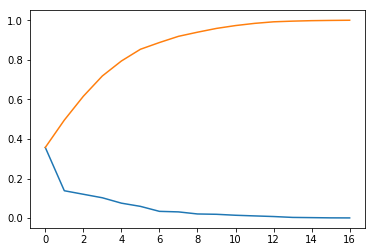

In [15]:
plt.plot(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

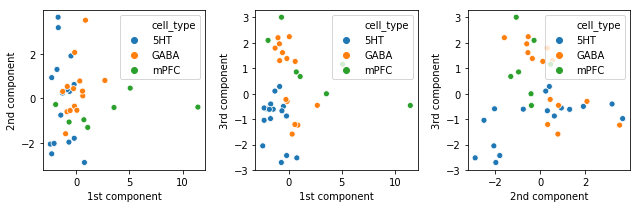

In [16]:
plt.figure(figsize=(9, 3))

plt.subplot(131)
sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=cell_types)
plt.xlabel('1st component')
plt.ylabel('2nd component')

plt.subplot(132)
sns.scatterplot(x=transformed[:, 0], y=transformed[:, 2], hue=cell_types)
plt.xlabel('1st component')
plt.ylabel('3rd component')

plt.subplot(133)
sns.scatterplot(x=transformed[:, 1], y=transformed[:, 2], hue=cell_types)
plt.xlabel('2nd component')
plt.ylabel('3rd component')

plt.tight_layout()
plt.show()

# ICA on whitened data

In [17]:
ica = FastICA(n_components=3)
ica_transformed = ica.fit_transform(transformed)
ica_transformed.shape

(37, 3)

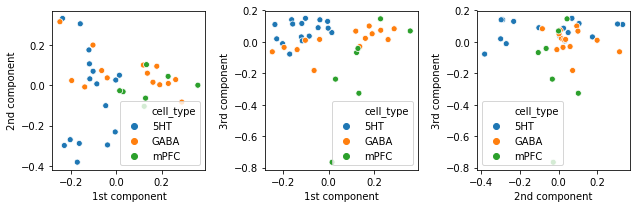

In [18]:
plt.figure(figsize=(9, 3))

plt.subplot(131)
sns.scatterplot(x=ica_transformed[:, 0], y=ica_transformed[:, 1], hue=cell_types)
plt.xlabel('1st component')
plt.ylabel('2nd component')

plt.subplot(132)
sns.scatterplot(x=ica_transformed[:, 0], y=ica_transformed[:, 2], hue=cell_types)
plt.xlabel('1st component')
plt.ylabel('3rd component')

plt.subplot(133)
sns.scatterplot(x=ica_transformed[:, 1], y=ica_transformed[:, 2], hue=cell_types)
plt.xlabel('2nd component')
plt.ylabel('3rd component')

plt.tight_layout()
plt.show()

# Train a classifier on PCA components

In [19]:
centered_svm = LinearSVC(fit_intercept=False)
centered_svm.fit(transformed[(cell_types != 'mPFC'), :], cell_types[(cell_types != 'mPFC')])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [20]:
centered_svm.coef_.shape

(1, 17)

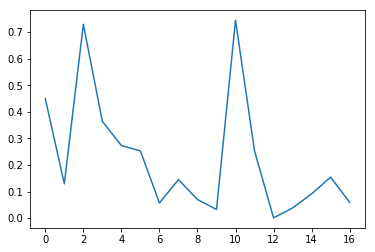

In [21]:
plt.plot(np.abs(centered_svm.coef_.T))

In [22]:
relative_importance = np.argsort(np.abs(centered_svm.coef_).flatten())
relative_importance

array([12,  9, 13,  6, 16,  8, 14,  1,  7, 15, 11,  5,  4,  3,  0,  2, 10])

In [23]:
def iteratively_drop_features(classifier, x, y):
    x = np.copy(x)
    y = np.copy(y)
    
    scores = []
    remaining_features = [i for i in range(x.shape[1])]
    feature_drop_order = []  # Features in order of increasing importance.
    for i in range(x.shape[1]):
        classifier.fit(x[:, remaining_features], y)
        scores.append(classifier.score(x[:, remaining_features], y))
        
        # Pop least important remaining feature.
        feature_drop_order.append(
            remaining_features.pop(np.argmin(np.abs(classifier.coef_)))
        )
    
    return scores, feature_drop_order
        

In [24]:
scores, feature_drop_order = iteratively_drop_features(
    centered_svm, 
    transformed[(cell_types != 'mPFC'), :], 
    cell_types[(cell_types != 'mPFC')]
)
scores

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8,
 0.7666666666666667]

We can separate 5HT and GABA cells perfectly using only three components.

In [25]:
print(feature_drop_order)

[12, 9, 13, 6, 8, 16, 1, 14, 7, 15, 5, 11, 4, 3, 2, 0, 10]


([<matplotlib.axis.XTick at 0x1a23f81710>,
 <a list of 17 Text xticklabel objects>)

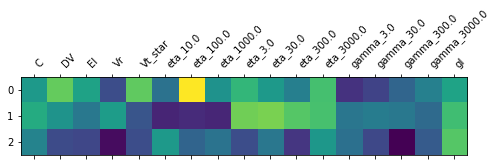

In [26]:
plt.figure(figsize=(8, 8))
plt.matshow(pca.components_[feature_drop_order[-1:-4:-1], :], fignum=False)
plt.xticks(np.arange(0, pca.components_.shape[1]), params_cleaned.columns.tolist(), rotation=45, ha='left')

# Train classifier on rescaled variables

## 5HT vs SOM

In [27]:
reduced_svm = LinearSVC(fit_intercept=False)
rescaled = rescale_variables(params_cleaned)
scores, feature_drop_order = iteratively_drop_features(
    reduced_svm, 
    np.asarray(rescaled)[cell_types != 'mPFC', :], 
    cell_types[cell_types != 'mPFC']
)
scores

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9,
 0.9333333333333333]

In [28]:
features_in_increasing_importance = np.array(params_cleaned.columns.tolist())[feature_drop_order]
features_in_increasing_importance

array(['gamma_30.0', 'El', 'eta_10.0', 'eta_30.0', 'C', 'gl', 'gamma_3.0',
       'eta_3000.0', 'Vr', 'gamma_3000.0', 'gamma_300.0', 'eta_3.0', 'DV',
       'Vt_star', 'eta_1000.0', 'eta_300.0', 'eta_100.0'], dtype='|S12')

Features in order of increasing importance.

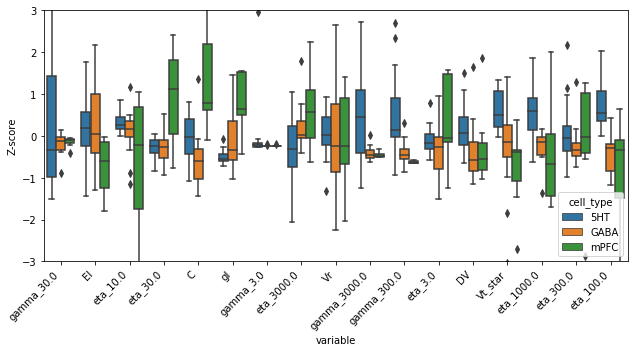

In [29]:
plt.figure(figsize=(9, 5))
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled, cell_types], axis=1).melt(id_vars='cell_type'),
    order = features_in_increasing_importance
)
plt.ylim(-3, 3)
tick_locs, tick_labs = plt.xticks()
plt.xticks(*plt.xticks(), rotation=45, ha='right')
plt.ylabel('Z-score')
plt.tight_layout()

## 5HT vs. mPFC

In [30]:
reduced_svm = LinearSVC(fit_intercept=False)
scores, feature_drop_order = iteratively_drop_features(
    reduced_svm, 
    np.asarray(rescaled)[cell_types != 'GABA', :], 
    cell_types[cell_types != 'GABA']
)
scores

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9565217391304348,
 0.9565217391304348,
 0.9565217391304348]

In [31]:
features_in_increasing_importance = np.array(params_cleaned.columns.tolist())[feature_drop_order]
features_in_increasing_importance

array(['Vr', 'gamma_3.0', 'eta_3.0', 'gamma_30.0', 'eta_30.0', 'El',
       'eta_1000.0', 'eta_300.0', 'gamma_3000.0', 'eta_3000.0',
       'gamma_300.0', 'DV', 'eta_100.0', 'C', 'eta_10.0', 'Vt_star', 'gl'],
      dtype='|S12')

Features in order of increasing importance.

Text(55.25,0.5,'Z-score')

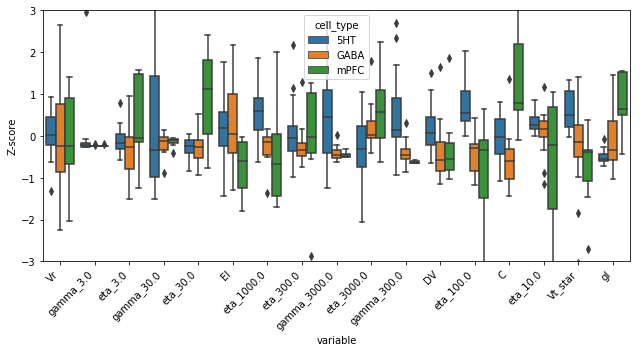

In [32]:
plt.figure(figsize=(9, 5))
sns.boxplot(
    x='variable', y='value', hue='cell_type', 
    data=pd.concat([rescaled, cell_types], axis=1).melt(id_vars='cell_type'),
    order = features_in_increasing_importance
)
plt.ylim(-3, 3)
tick_locs, tick_labs = plt.xticks()
plt.xticks(*plt.xticks(), rotation=45, ha='right')
plt.tight_layout()
plt.ylabel('Z-score')